# Pseudo-spectral method to solve the Swift-Hohenberg equation

In this exercise we want to solve the Swift-Hohenberg (SH) equation numerically

\begin{equation}
\partial_t u = \left[ \epsilon - (q_0^2+\partial_x^2)^2\right]\ u - u^3
\end{equation}

For this we want to use the method of operator splitting. The idea behind operator splitting is to divide the right hand side into two operators, one linear operator containing the highest-order spatial derivatives $\mathcal{L}$ and one nonlinear operator containing the remaining terms $\mathcal{N}$. The linear part and the nonlinear part can then be solved independently, using different numerical approaches.

Consider the linear part

\begin{equation}
\mathcal{L}u = \left[ \epsilon - (q_0^2+\partial_x^2)^2\right]\ u,
\end{equation}

and the nonlinear part

\begin{equation}
\mathcal{N}(u) = -u^3.
\end{equation}

**To hand in your solution, you may edit this jupyter notebook and print a pdf via `File -> Download as -> PDF via LaTeX`. Make sure that all parts of your code are readable (if not introduce linebreaks `\`). Don't forget to run all cells to include all plots. Also please create new Markdown cells for written answers. Cells are added via `Insert` and they are changed to Markdown via `Cell -> Cell Type -> Markdown`.**





### (a) Solving the linear part (3 points)

Before we can apply the full algorithm, we want to implement a few functions in preparation.
Our simulation is supposed to solve the SH equaation starting from random initial data.

1. Implement the function `create_random_array`, which should return an array of size $number$ (or in 2D of size $(number,number)$) of independent random values drawn uniformly from $[-amplitude, amplitude)$.

We will solve the linear part via transformation into fourier space. We consider the function $u$ on an interval of length $L$ at the discretization points $x_n=nL/N$, $n=0,...,N-1$.

The Fourier transform of the function $u$, which is known at discrete points, can be approximated as
\begin{equation}
\hat{u}(q_n) = \frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N}\mathrm{e}^{-i q_n x_k}\ u(x_k) \frac{1}{L},
\end{equation}
with wave numbers $q_n=2\pi nL/N$, where the wave numbers with $n=0,...,N$ are sufficient to reconstruct the original $u$, because we cannot resolve more modes. The inverse transform is then given via
\begin{equation}
u(x_k) = \frac{1}{\sqrt{2\pi}}\sum_{n=0}^{N}\mathrm{e}^{i q_n x_k}\ \hat{u}(q_n) \frac{2\pi L}{N}.
\end{equation}

We will now use the Discrete Fourier Transform (DFT) to approximate the Fourier transform of our discretized function and the inverse DFT to reconstruct a signal from Fourier space. In `scipy` Fast Fourier Transform methods are implemented to calculate this numerically. A tutorial on the implementation is given in: https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html.

2. Read the tutorial on FFT from the SciPy documentation. How is the DFT defined that is used in SciPy and why doesn't it make any difference?
    Implement the function `create_wavenumber_array`, which should return an array of the wave numbers $q_n$ in the correct ordering used by SciPy.
    *Hint: Look at `fftfreq`.*

Now we want to solve the linear part of the SH equation
\begin{equation}
\partial_t u = \mathcal{L}u = \left[ \epsilon - (q_0^2+\partial_x^2)^2\right]\ u.
\end{equation}

For this we use a Fourier transform of the spatial domain on the linear equation and solve the resulting differential equation. One can see that advancing the Fourier transform by a timestep $\Delta t$ in Fourier space can be written as an operator, which acts on the Fourier representation of $u(t)$.

3. Show that in Fourier space, for the linear part of the SH equation the time evolution from initial condition $\hat{u}(t, q_n)$ for a timestep $\Delta t$ and wavenumber $q_n$ is given by
    \begin{equation}
    \hat{u}(t+\Delta t,q_n) = \exp\left(\left[\epsilon - (q_0^2-q_n^2)^2\right]\cdot \Delta t\right)\cdot \hat{u}(t,q_n).
    \end{equation}

    Implement this operator in `create_time_evolution_operator`, which should return the operator as an array. (Note: Remember the ordering of the wavenumbers!)

*Extra points: Implement the 2D case.*

#### Solution 2.

By rescaling $L = \frac{1}{\sqrt {2 \pi}}$ in our DFT definition, we can see that it's equivalent to the one defined on SciPy wiki.
After using the inverse transform, we get the same result.

#### Solution 3.

let
$$
u = u(t,x), \quad \hat u = \mathcal{F} u(t,x) = \hat u(t,q)
$$
transform the linear part of the equation
$$
\mathcal{F} [\partial_t u] = \mathcal{F}[\mathcal{L} u]
$$
$$
\partial_t \hat u = \hat L \hat u
$$
where
$$
\mathcal{F} [\partial_x^2 u(t, x)] = -q^2 \hat u(t,q)  \implies \hat L = \epsilon - (q_0^2 - q^2)^2
$$
integrating:
$$
\hat u(t + \Delta t, q) = \operatorname{exp}(\Delta t \hat L) \hat u(t,q)
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.fft import fft, fft2, ifft, fftn, ifft2, ifftn, fftfreq

In [2]:
N = 64 * 2  # Num of discretisation points

L = 10.0 * 2.0 * np.pi
dt = 0.005
q02 = 1.0  # q0^2 of SH model, should be kept 1
NUM_STEPS = 100000
epsilon = 0.1  # epsilon of SH model
alpha = 0.1  # alpha for the quadratic term in SH model

dx = L / N

In [3]:
def create_random_array(number=N, amplitude=0.01, two_dim=False):
    """
    This function should create an array of size N, which is initialized with random numbers drawn
    from the uniform distribution in [-amplitude, amplitude).

    Args:
        number (int): number of elements in random array
        amplitude (float): amplitude of random array
    Return: random array
    """
    size = (number, number) if two_dim else (number,)
    return amplitude * (np.random.rand(*size) * 2 - 1)


def create_wavenumber_array(num_modes=N):
    """
    This function should create an array of size N, which is initialized with the wavenumbers.

    Args:
        number (int): number of wavenumbers
    Return: array
    """
    return fftfreq(n=num_modes, d=dx)


def create_time_evolution_operator(
    wavenums, zero_wavenum=q02, eps=epsilon, two_dim=False, dt=dt
):
    """
    This function should create the time evolution operator in fourier space, which is of size
    (num_nodes) in 1D and (num_nodes,num_nodes) in 2D.
    If you want you can program the 2D case and use the flag two_dim to differentiate between the cases.

    Args:
        wavenums (array): wavenumbers in one dimension for the evolution operator, ordered correctly for SciPy FFT
        zero_wavenum (float): q_0^2 term in SH equation - standard value was defined above
        eps (float): epsilon in SH equation - standard value was defined above
        two_dim (bool): Wether to return the 2D operator
    Return: array containing the time evolution operator
    """
    res = np.exp(dt * (eps - (zero_wavenum - wavenums**2) ** 2))
    if two_dim:
        return np.outer(res, res)
    return res

### (b) Implementing the operator-split Pseudo-spectral method  (2 points)

Now that we have implemented an operator to solve the linear part, we can look at the nonlinear part

\begin{equation}
\partial_t u = \mathcal{N}(u) = -u^3,\quad \text{initial data:}\quad u(t).
\end{equation}

This we can integrate using Euler stepping (i.e. linear extrapolation). The equation to approximate the solution of the nonlinear equation at $t+\Delta t$, i.e. $\tilde{u}_t$ is then

\begin{equation}
\tilde{u}_t = u(t)-u(t)^3 \Delta t.
\end{equation}

Now implement the operator splitting method, as described on the sheet and above.
For this implement `perform_simulation`. You should generate random initial data using `create_random_array`, generate the wavenumbers in the correct ordering with `create_wavenumber_array`, use these to create the time evolution operator in fourier space with `create_time_evolution_operator` and then integrate the SH equation with the algorithm, saving each step into an array/list, which you output for plotting. To solve the linear system, you have to fourier transform the output of the nonlinear equation, apply the time evolution operator and then transform back into real space.

*Extra points: Implement the 2D case with the quadratic nonlinear term $-\alpha u^2$.*

In [4]:
def perform_simulation(
    num_steps=NUM_STEPS,
    timestep=dt,
    two_dim=False,
    num_modes=N,
    quadratic=False,
    alpha_quad=alpha,
    eps=epsilon,
):
    """
    This function solves the Swift Hohenberg equation with operator splitting and a pseudospectral method.
    It should create noisy initial data with the function "create_random_array", the wavenumbers to be considered
    with "create_wavenumber_array" and the time evolution operator with "create_time_evolution_operator".
    Then it should integrate the SH equation with the pseudospectral method, using fft & ifft (1D) or
    fftn & ifftn (2D).

    Args:
        num_steps (int): Number of timesteps to integrate - standard value was defined above
        timestep (float): Size of one timestep to integrate - standard value was defined above
        two_dim (bool): Wether to return the 2D operator
        num_modes (int): number of modes - standard value was defined above
        quadratic (bool): Wether to include the quadratic term
        alpha_quad (float): alpha coefficient of the quadratic term
        eps (float): epsilon in SH equation
    Return: array, array containing the solutions and the respective times
    """
    ic = create_random_array(number=num_modes, amplitude=0.001, two_dim=two_dim)
    wn = create_wavenumber_array(num_modes)
    te = create_time_evolution_operator(wn, eps=eps, two_dim=two_dim, dt=timestep)

    nonlinearity = lambda x: - x**3
    if quadratic:
        nonlinearity = lambda x: -alpha_quad * x**2 - x**3

    t_fft = fft
    t_ifft = ifft

    if two_dim:
        t_fft = fft2
        t_ifft = ifft2

    space = ic
    steps = [ic]
    for _ in range(num_steps):
        freq = t_fft(space)
        space = t_ifft(te * freq)
        space = space + dt * nonlinearity(space)
        steps.append(space.real)
    return np.array(steps)

### (c) Plot your results (2 points)

Plot the results of a simulation with $\varepsilon=0.1$ as a 3D surface plot (u as a function of x and t). You can use `plt.plot_surface` for this. (To get a nicer perspective you should look at `view_init`.) Additionally, plot the simulation results $u$ as a function of $x$ for a few interesting times.

*Extra points: Plot the 2D case with and without the quadratic nonlinear term $-\alpha u^2$ for a few times $t$. You may use `plt.pcolormesh` for this. It makes sense to use N=64 here for faster computations.*

In [5]:
sim = perform_simulation()

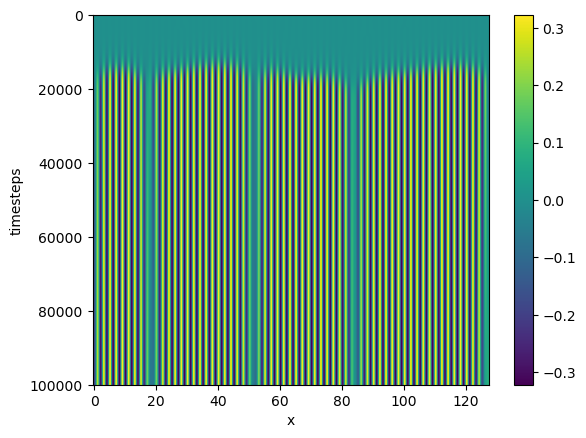

In [6]:
plt.imshow(sim, aspect="auto", cmap="viridis")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("timesteps")
plt.show()

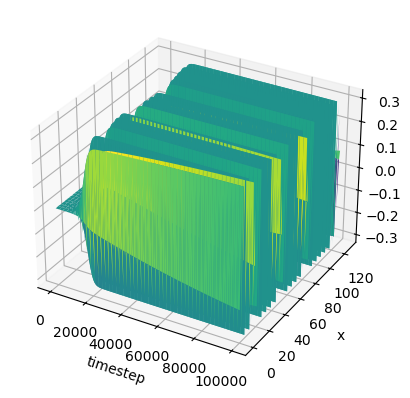

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x = np.arange(sim.shape[1])
t = np.arange(sim.shape[0])
X, T = np.meshgrid(x, t)

ax.plot_surface(T, X, sim, cmap="viridis")
ax.set_xlabel("timestep")
ax.set_ylabel("x")
plt.show()

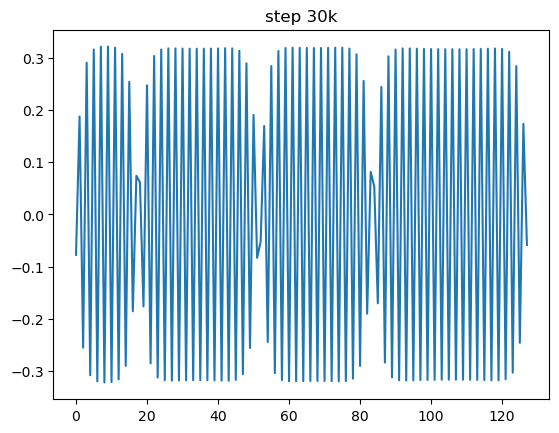

In [8]:
plt.plot(sim[30000, :])
plt.title("step 30k")
plt.show()

In [ ]:
sim2d = perform_simulation(two_dim=True, num_steps=1000000, num_modes=64)

In [ ]:
plt.imshow(sim2d[-1, :, :])

In [41]:
sim2d_quad = perform_simulation(two_dim=True, quadratic=True, alpha_quad=6, num_steps=300000, num_modes=64)

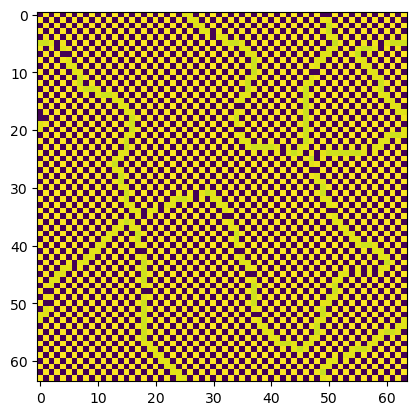

In [42]:
plt.imshow(sim2d_quad[-1, :, :])

### (d) Comparison to the amplitude equation (1 point)

In the lecture we derived an amplitude equation for the SH equation. Plotting the result in 1D, you should notice that the pattern has grown over a period of time and then remained constant. We now want to check our simulation against the analytical result.

1. For $\epsilon=0.1$ plot the squared amplitude $A^2$ of the pattern you found as a function of the simulation time to check whether your simulation has converged.

2. Calculate the squared amplitde $A^2$ for $\epsilon=0.05,\ 0.1,\ 0.2,\ 0.3,\ 0.4,\ 0.5$. What is the theoretical expectation for $A^2$ as a function of $\epsilon$? Plot the expectation and the simulation results for $A^2(\epsilon)$.



$$
\begin{gathered}
\epsilon + 4q_0^2q^2 - 3A^2 = 0 \\
A^2 = \frac{1}{3}(4q_0^2q^2 + \epsilon)
\end{gathered}
$$

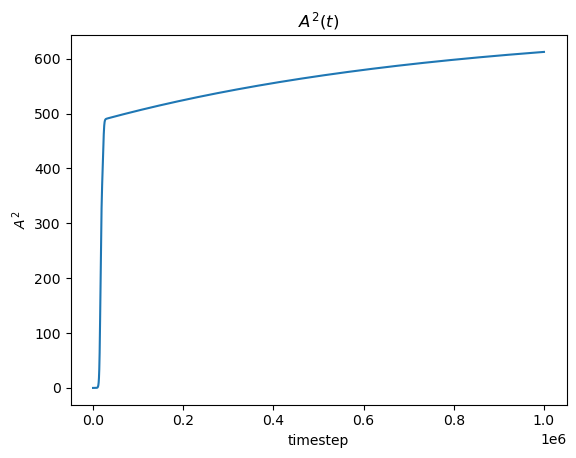

In [322]:
sim = perform_simulation(num_steps=1000000)
freq = fft(sim, axis=1)
a02 = np.max(np.abs(freq),axis=1)**2
plt.plot(a02)
plt.title('$A^2(t)$')
plt.ylabel('$A^2$')
plt.xlabel('timestep')
plt.show()

In [347]:
def get_a2(eps, n_steps = 1000000, convergence_threshold = 0.05):
    sim = perform_simulation(num_steps=n_steps, eps=eps)
    freq = fft(sim, axis=1)
    a02 = np.max(np.abs(freq),axis=1)**2
    for i in range(n_steps//2, n_steps):
        if abs((a02[i] - a02[-1])/a02[-1]) > convergence_threshold:
            return None
    return a02[-1]

def get_a2_with_retries(eps, attempts = 100, nuff = 5):
    samples = []
    for _ in range(attempts):
        res = get_a2(eps)
        if res is not None:
            samples.append(res)
        if len(samples) > 5:
            break
    if len(samples) == 0:
        return None
    return np.mean(samples)

In [348]:
eps_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
eps_a02 = [get_a2_with_retries(i) for i in eps_values]

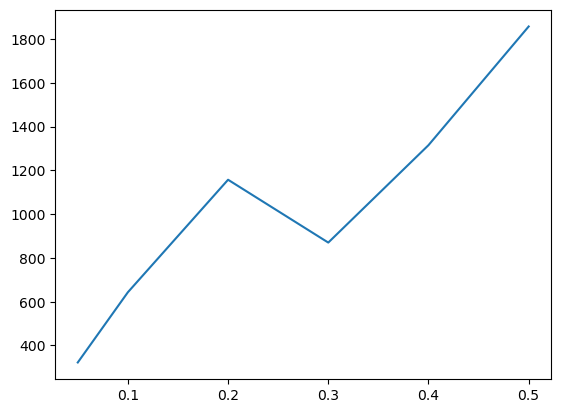

In [351]:
plt.plot(eps_values, eps_a02)

for some reason doesn't converge most of the time, would maybe work out if averaged out over a big number of better sets of initial conditions